In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from plots import bound_plot

In [4]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def f_e1(X, wd, Z, beta):
    return sigmoid(wd[0] + wd[1]*X[:,0] + wd[2]*X[:,1] + wd[3]*X[:,2] + wd[4]*X[:,3] + wd[5]*X[:,4]+ beta*Z)

def f_a(X, wa):
    return sigmoid(wa[0] + wa[1]*X[:,0] + wa[2]*X[:,1] + wa[3]*X[:,2])

def f_mu(X, wm):
    return sigmoid(wm[0] + wm[1]*X[:,0] + wm[2]*X[:,1] + wm[3]*X[:,2] + wm[4]*X[:,3] + wm[5]*X[:,4])


## Iterate on a realistic DGP

In [111]:

def generate_data(dgp):

    N = dgp['N']
    Z = np.random.choice(dgp['nz'], N).astype(np.float64)
    X = np.random.normal(0, 1, size=(N,5))

    pD = f_e1(X, dgp['wd'], Z, dgp['beta'])
    pA = f_a(X, dgp['wa'])
    pY = f_mu(X, dgp['w_mu1'])*pD + f_mu(X, dgp['w_mu0'])*(1-pD)

    D = np.random.binomial(1, pD, size=N)
    A = np.random.binomial(1, pA, size=N)
    Y = np.random.binomial(1, pY, size=N)
    
    age = np.zeros_like(pD)
    age[X[:,0]<0] = np.random.binomial(1, .1, size=N)[X[:,0]<0]
    age[X[:,0]>=0] = np.random.binomial(1, .8, size=N)[X[:,0]>=0]

    race = np.zeros_like(pD)
    race[X[:,1]<-.2] = np.random.binomial(1, .7, size=N)[X[:,1] <- .2]
    race[(X[:,1] >= -.2) & (X[:,1] < .2)] = np.random.binomial(1, .8, size=N)[(X[:,1] >= -.2) & (X[:,1] < .2)]
    race[(X[:,1] >= .2)] = np.random.binomial(1, .9, size=N)[(X[:,1] >= .2)]
    

    return {
        'X': X, 
        'Z': Z, 
        'D': D, 
        'Y': Y, 
        'A': A,
        'age': age,
        'race': race
    }


def one_step_bounds(data, dgp, u, metric, use_iv=True):
    
    A, D, Y = data['A'], data['D'], data['Y']
    
    if use_iv: 
        v10_down, v10_up = get_iv_bounds(data, dgp, a=1, true_class=1)
        v00_down, v00_up = get_iv_bounds(data, dgp, a=0, true_class=1)
        
        w10_down, w10_up = get_iv_bounds(data, dgp, a=1, true_class=0)
        w00_down, w00_up = get_iv_bounds(data, dgp, a=0, true_class=0) 
    
    else: 
        v10_down, v00_down = 0, 0
        v10_up = ((A==1) & (D==0)).mean()
        v00_up = ((A==0) & (D==0)).mean()
        
        w10_down, w00_down = 0, 0
        w10_up = ((A==1) & (D==0)).mean()
        w00_up = ((A==0) & (D==0)).mean()

    v11 = ((D==1) & (A==1) & (Y==1)).mean()
    v01 = ((D==1) & (A==0) & (Y==1)).mean()
    
    w11 = ((D==1) & (A==1) & (Y==0)).mean()
    w01 = ((D==1) & (A==0) & (Y==0)).mean()
    
    if metric=='FNR':
        d = v00_up if v01 > v10_up else v00_down
        R_down = (v01 - v10_up)/ (d + v10_up + v01 + v11)
        
        u = v00_down if v01 > v10_down else v00_up
        R_up = (v01 - v10_down)/ (u + v10_down + v01 + v11)
        
    elif metric=='TNR':
        d = w00_up if w01 > w10_up else w00_down
        R_down = (w01 - w10_up)/(d+w10_up+w01+w11)
        
        c = w00_down if w01 > w10_down else w00_up
        R_up = (w01 - w10_down)/(c+w10_down+w01+w11)
        
    elif metric=='TPR':
        d = v00_up if v10_down > v01 else v00_down
        R_down = (v10_down - v01)/ (d + v10_down + v01 + v11)
        
        c = v00_down if v10_up > v01 else v00_up
        R_up = (v10_up - v01)/ (c + v10_up + v01 + v11)
        
    elif metric=='FPR':
        d = w00_up if w10_down > w01 else w00_down
        R_down = (w10_down-w01)/(d+w10_down+w01+w11)
        
        u = w00_down if w10_up > w01 else w00_up
        R_up = (w10_up-w01)/(u+w10_up+w01+w11)
        
    elif metric=='ACCURACY':
        R_down = w01 + v10_down - w10_up - v01
        R_up = w01 + v10_up - w10_down - v01
        
    elif metric=='PV':
        R_down = u[0,0]*(w01-w10_up) + u[0,1]*(v01-v10_up) + u[1,0]*(w10_down-w01)+u[1,1]*(v10_down-v01)
        R_up = u[0,0]*(w01-w10_down) + u[0,1]*(v01-v10_down) + u[1,0]*(w10_up-w01)+u[1,1]*(v10_up-v01)
        
    elif metric=='PV_cost':
        R_down = u[0,0]*(w01-w10_down) + u[0,1]*(v01-v10_down) + u[1,0]*(w10_up-w01)+u[1,1]*(v10_up-v01)
        R_up = u[0,0]*(w01-w10_up) + u[0,1]*(v01-v10_up) + u[1,0]*(w10_down-w01)+u[1,1]*(v10_down-v01)
        
    return R_down, R_up

def two_step_bounds(data, dgp, u, metric, use_iv=True):
    
    A, D, Y = data['A'], data['D'], data['Y']
    
    if use_iv: 
        v10_down, v10_up = get_iv_bounds(data, dgp, a=1, true_class=1)
        v00_down, v00_up = get_iv_bounds(data, dgp, a=0, true_class=1)
        
        w10_down, w10_up = get_iv_bounds(data, dgp, a=1, true_class=0)
        w00_down, w00_up = get_iv_bounds(data, dgp, a=0, true_class=0)      
        
    else:
        v10_down, v00_down = 0, 0
        v10_up = ((A==1) & (D==0)).mean()
        v00_up = ((A==0) & (D==0)).mean()
        
        w10_down, w00_down = 0, 0
        w10_up = ((A==1) & (D==0)).mean()
        w00_up = ((A==0) & (D==0)).mean()
        
    v10_true = ((A==1) & (D==0) & (Y==1)).mean()
    v00_true = ((A==0) & (D==0) & (Y==1)).mean()
    w10_true = ((A==1) & (D==0) & (Y==0)).mean()
    w00_true = ((A==0) & (D==0) & (Y==0)).mean()
    
    eps = .01
    assert v10_down-eps <=  v10_true <= v10_up+eps, f'v10: {v10_true:.2}. IV bound [{v10_down:.2}, {v10_up:.2}]'
    assert v00_down-eps <=  v00_true <= v00_up+eps, f'v00: {v00_true:.2}. IV bound [{v00_down:.2}, {v00_up:.2}]'
    assert w00_down-eps <=  w00_true <= w00_up+eps, f'w00: {w00_true:.2}. IV bound [{w00_down:.2}, {w00_up:.2}]'
    assert w10_down-eps <=  w10_true <= w10_up+eps, f'w10: {w10_true:.2}. IV bound [{w10_down:.2}, {w10_up:.2}]'

    
    v11 = ((D==1) & (A==1) & (Y==1)).mean()
    v01 = ((D==1) & (A==0) & (Y==1)).mean()
    
    w11 = ((D==1) & (A==1) & (Y==0)).mean()
    w01 = ((D==1) & (A==0) & (Y==0)).mean()
    
    if metric=='FNR':
    
        TS_down = (v00_down + v01)/(v00_down + v10_up + v01 + v11) - \
                (v00_up + v10_up)/(v00_up + v10_up + v01 + v11)

        TS_up = (v00_up + v01) / (v00_up + v10_down + v01 + v11) - \
                (v00_down + v10_down)/(v00_down + v10_down + v01 + v11)
        
    elif metric=='TPR':
        
        TS_down = (v11 + v10_down)/(v00_up + v10_down + v01 + v11) -\
                 (v11 + v01)/(v00_down + v10_down + v01 + v11)
        
        TS_up = (v11 + v10_up)/(v00_down+v10_up+v01+v11) -\
                (v11 + v01)/(v00_up+v10_up+v01+v11)
        
    elif metric=='TNR':
       
        TS_down = (w00_down+w01)/(w00_down+w10_up+w01+w11) -\
                  (w00_up+w10_up)/(w00_up+w10_up+w01+w11)
        
        TS_up = (w00_up+w01)/(w00_up+w10_down+w01+w11) -\
                (w00_down+w10_down)/(w00_down+w10_down+w01+w11)  
    
    elif metric=='FPR':
        
        TS_down = (w10_down+w11)/(w00_up+w10_down+w01+w11) -\
                  (w01+w11)/(w00_down+w10_down+w01+w11)
        
        TS_up = (w10_up+w11)/(w00_down+w10_up+w01+w11) -\
                (w01+w11)/(w00_up+w10_up+w01+w11)
        
    elif metric=='ACCURACY':
        
        TS_down = (w00_down+v10_down + w01+v11) - (w00_up+w10_up+v11+v01)
        
        TS_up =   (w00_up + w01 + v10_up + v11) - (w00_down+w10_down+v11+v01)
        
    elif metric=='PV':
        
        TS_down = u[0,0]*(w00_down+w01)+u[0,1]*(v00_down+v01) + u[1,0]*(w10_down+w11) + u[1,1]*(v10_down+v11) -\
                  (u[0,0]*(w00_up+w10_up)+u[0,1]*(v00_up+v10_up) + u[1,0]*(w01+w11) + u[1,1]*(v01+v11))
            
        TS_up = u[0,0]*(w00_up+w01)+u[0,1]*(v00_up+v01) + u[1,0]*(w10_up+w11) + u[1,1]*(v10_up+v11) -\
                (u[0,0]*(w00_down+w10_down)+u[0,1]*(v00_down+v10_down) + u[1,0]*(w01+w11) + u[1,1]*(v01+v11))
    
    elif metric=='PV_cost':
        
        TS_down = u[0,0]*(w00_up+w01)+u[0,1]*(v00_up+v01) + u[1,0]*(w10_up+w11) + u[1,1]*(v10_up+v11) -\
                  (u[0,0]*(w00_down+w10_down)+u[0,1]*(v00_down+v10_down) + u[1,0]*(w01+w11) + u[1,1]*(v01+v11))
            
        TS_up = u[0,0]*(w00_down+w01)+u[0,1]*(v00_down+v01) + u[1,0]*(w10_down+w11) + u[1,1]*(v10_down+v11) -\
                (u[0,0]*(w00_up+w10_up)+u[0,1]*(v00_up+v10_up) + u[1,0]*(w01+w11) + u[1,1]*(v01+v11))
    
    return TS_down, TS_up

def oracle_regret(data, u, metric):
    
    A, D, Y = data['A'], data['D'], data['Y']
    
    if metric=='FNR':
        regret = ((A==0) & (Y==1)).mean() / (Y==1).mean() - ((D==0) & (Y==1)).mean() / (Y==1).mean()
        
    if metric=='TNR':
        regret = ((A==0) & (Y==0)).mean() / (Y==0).mean() - ((D==0) & (Y==0)).mean() / (Y==0).mean()

    elif metric=='TPR':
        regret = ((A==1) & (Y==1)).mean() / (Y==1).mean() - ((D==1) & (Y==1)).mean() / (Y==1).mean()
        
    elif metric=='FPR':
        regret = ((A==1) & (Y==0)).mean() / (Y==0).mean() - ((D==1) & (Y==0)).mean() / (Y==0).mean()
        
    elif metric=='ACCURACY':
        regret = (A==Y).mean() - (D==Y).mean()
        
    elif metric=='PV' or metric=='PV_cost':
        Vpi = u[0,0]*((A==0) & (Y==0)).mean() + u[0,1]*((A==0) & (Y==1)).mean() + u[1,0]*((A==1) & (Y==0)).mean() + u[1,1]*((A==1) & (Y==1)).mean()
        Vpi0 = u[0,0]*((D==0) & (Y==0)).mean() + u[0,1]*((D==0) & (Y==1)).mean() + u[1,0]*((D==1) & (Y==0)).mean() + u[1,1]*((D==1) & (Y==1)).mean()
        
        regret = Vpi-Vpi0
    
    return regret
    
    
def get_iv_bounds(data, dgp, a, true_class=1):
    
    X, Z, A, D, Y = data['X'], data['Z'], data['A'], data['D'], data['Y']
    nz, N = dgp['nz'], data['X'].shape[0]
    if true_class==0:
        Y = 1-Y
    
    mu_down_z = np.zeros((nz, N))
    mu_up_z = np.zeros((nz, N))

    # Compute upper and lower bounds on mu(a,x)
    for z in range(nz):
        e1_z = f_e1(X, dgp['wd'], z, dgp['beta'])
        e0_z = 1-e1_z
        
        if true_class==1:
            mu1 = f_mu(X, dgp['w_mu1'])
        else:
            mu1 = 1-f_mu(X, dgp['w_mu1'])

        mu_down_z[z] = e1_z*mu1
        mu_up_z[z] = e0_z + e1_z*mu1

    mu_down = mu_down_z.max(axis=0)
    mu_up = mu_up_z.min(axis=0)

    z_down= np.zeros((nz, N))
    z_up= np.zeros((nz, N))

    for z in range(nz):

        e1_z = f_e1(X, dgp['wd'], z, dgp['beta'])
        e0_z = 1-e1_z
        if true_class==1:
            mu1 = f_mu(X, dgp['w_mu1'])
        else:
            mu1 = 1-f_mu(X, dgp['w_mu1'])

        lower = (mu_down - mu1*e1_z)/e0_z
        upper = (mu_up - mu1*e1_z)/e0_z

        marginal = ((Z==z) & (A==a) & (D==0)).mean()*(1/N)

        z_down[z] = np.clip(lower, a_min=0, a_max=1)*marginal
        z_up[z] = np.clip(upper, a_min=0, a_max=1)*marginal

    # Compute overall bounds on unobserved cells
    v_down = z_down.sum(axis=0).sum(axis=0)
    v_up = z_up.sum(axis=0).sum(axis=0)
    
    return v_down, v_up

def compare_bounds(data, dgp, tag, pg, u, metric, run=0):
    
    TS_down_iv, TS_up_iv = two_step_bounds(data, dgp, u, metric=metric, use_iv=True)
    OS_down_iv, OS_up_iv = one_step_bounds(data, dgp, u, metric=metric, use_iv=True)

    TS_down_wc, TS_up_wc = two_step_bounds(data, dgp, u, metric=metric, use_iv=False)
    OS_down_wc, OS_up_wc = one_step_bounds(data, dgp, u, metric=metric, use_iv=False)

    R_star = oracle_regret(data, u, metric=metric)

    return {
        'TS_down_iv': TS_down_iv,
        'TS_up_iv': TS_up_iv,
        'OS_down_iv': OS_down_iv,
        'OS_up_iv': OS_up_iv,
        'TS_down_wc': TS_down_wc,
        'TS_up_wc': TS_up_wc,
        'OS_down_wc': OS_down_wc,
        'OS_up_wc': OS_up_wc,
        'SR': data['D'].mean(),
        'pG': pg,
        'tag': tag,
        'R': R_star,
        'run': run
    }

def run_simulations(dgp, u, metric, n_runs):
    
    results = []
    
    for run in range(n_runs):
        
        data = generate_data(dgp)
        
        gx=1
        for a in [0, 1]:
            for r in [0, 1]:
                
                
                g = ((data['age']==a) & (data['race']==r))

                data_g = {
                    'X': data['X'][g],
                    'Z': data['Z'][g],
                    'D': data['D'][g],
                    'Y': data['Y'][g],
                    'A': data['A'][g],
                }
                
                outmean = ((data['D'][g] == 0) & (data['A'][g] == 0)).mean()

                tag = f'G{gx}'
                gx=gx+1
                results.append(compare_bounds(data_g, dgp, tag, g.mean(), u, metric, run))

        results.append(compare_bounds(data, dgp, 'Population', 1, u, metric, run))
    
    return pd.DataFrame.from_dict(results) 
    

In [122]:
nz = 10
dgp = {
    'N': 10000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}



u = np.array([[0,-1], [-20, 0]])

# u = np.array([[TN,FN], [FP, TP]])

metric='TNR'
regret_runs = run_simulations(dgp, u, metric=metric, n_runs=10)
regret_df = regret_runs.groupby(['tag']).mean().reset_index()

regret_df = regret_df.sort_values(by='tag', ascending=True)
regret_runs = regret_runs.sort_values(by='tag', ascending=True)


## Main result plot

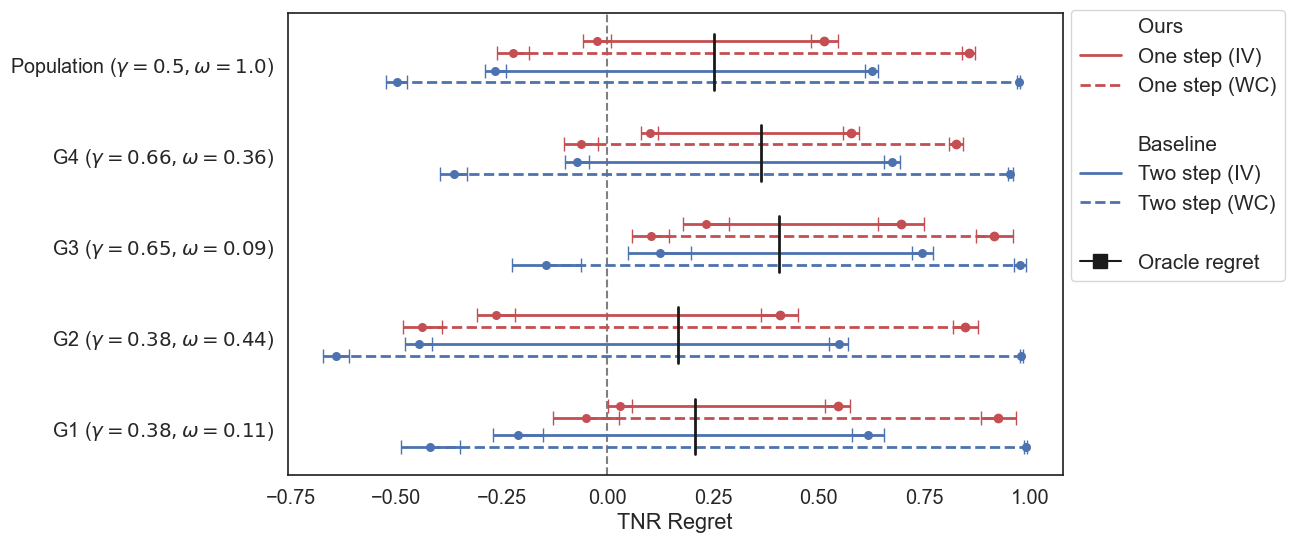

In [123]:
bound_plot(metric, regret_df, regret_runs, save=False)

In [95]:
data = generate_data(dgp)

((data['A'] == 0) & (data['D'] == 0)).mean()

0.2998

In [161]:
nz = 10
n_runs = 20
dgp = {
    'N': 10000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}

results = []

for fn_cost in range(1,21):
    u = np.array([[0,-fn_cost], [-1, 0]])
    regret_runs = run_simulations(dgp, u, metric='PV_cost', n_runs=n_runs)
    regret_runs['cost_ratio'] = 1/fn_cost
    results.append(regret_runs)

for fp_cost in range(1,21):
    u = np.array([[0,-1], [-fp_cost, 0]])
    regret_runs = run_simulations(dgp, u, metric='PV_cost', n_runs=n_runs)
    regret_runs['cost_ratio'] = fp_cost/1
    results.append(regret_runs)


/var/folders/qg/2fjh2ncx3j1d_fc1_sjwnzdm0000gp/T/ipykernel_22414/1076036927.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  crdf = crdf.groupby('cost_ratio').mean().reset_index()


Text(0, 0.5, 'PV Regret')

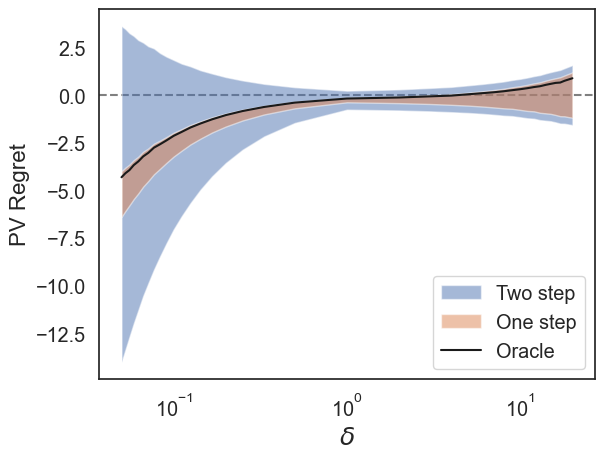

In [174]:
crdf = pd.concat(results)
crdf = crdf[crdf['tag'] == 'Population']
crdf = crdf.sort_values(by='cost_ratio')
crdf = crdf.groupby('cost_ratio').mean().reset_index()


plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.fill_between(crdf['cost_ratio'], crdf['TS_down_wc'],crdf['TS_up_wc'], alpha=.5, label='Two step')
plt.fill_between(crdf['cost_ratio'], crdf['OS_down_wc'],crdf['OS_up_wc'], alpha=.5, label='One step')
plt.plot(crdf['cost_ratio'], crdf['R'], color='k', label='Oracle')
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('PV Regret', fontsize=16)

# plt.plot(crdf['cost_ratio'], crdf['OS_up_iv'])